<a href="https://colab.research.google.com/github/alptugo/me536_final_countdown/blob/main/Lattice_segm_classifier_amc2024_novelty_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import sample
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Dropout
from tensorflow.keras.metrics import binary_crossentropy
import pickle

#Giving the directory of the folder by folder 4 channel images
path = "/content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/"
lattice_types  = os.listdir(path)

#defining label to number mapping dictionary
label_map = {label:num for num, label in enumerate(lattice_types)}

#getting random lattice types to exclude from trainning
# excluded_lattice_types=[lattice_types[i] for i in sample(range(14), 3)]
excluded_lattice_types=[]

print(f"I excluded {excluded_lattice_types}")

#for the first 200 images of every lattice types, opens them, transforms their
#channels to binary (from 0 or 255 to 0 or 1). Gets the images and labels to different
#lists depending on wether they are excluded or not
sequences, excluded_sequences, labels, excluded_labels = [], [], [], []
for lattice_type in lattice_types:
    #for sequence in range(200):
    for sequence in range(200):

      img = Image.open("{}{}/{} ({}).png".format(path, lattice_type, lattice_type, sequence+1))
      img_array = np.array(img)
      img_array = img_array / 255.0
      if lattice_type not in excluded_lattice_types:
          sequences.append(img_array)
          labels.append(label_map[lattice_type])
      else:
          excluded_sequences.append(img_array)
          excluded_labels.append(label_map[lattice_type])

I excluded []


In [ ]:
len(sequences)

2800

In [ ]:
label_map

{'Body centered cubic': 0,
 'Column': 1,
 'Diamond': 2,
 'Re-entrant': 3,
 'Kelvin cell': 4,
 'IsoTruss': 5,
 'Columns': 6,
 'Octet': 7,
 'Face centered cubic': 8,
 'Fluorite': 9,
 'Simple cubic': 10,
 'Truncated octahedron': 11,
 'Truncated cube': 12,
 'Weaire-Phelan': 13}

In [ ]:
new_label_map={label:num for num, label in enumerate([lattice_type for lattice_type in lattice_types if lattice_type not in excluded_lattice_types])}


In [ ]:
old_to_new_label_map={}
for key in label_map.keys():
  if key in new_label_map.keys():
    old_to_new_label_map = {**old_to_new_label_map, label_map[key]: new_label_map[key]}
old_to_new_label_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13}

In [ ]:
labels=[old_to_new_label_map[label] for label in labels]

In [ ]:
y = tf.keras.utils.to_categorical(labels).astype(int)
y.shape

(2800, 14)

In [ ]:
X = np.array(sequences)
print(X.shape)

X_by_examples=np.array_split(X, 14)

#X_by_examples=X
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)


(2800, 48, 48, 4)


In [ ]:
X.shape

(2800, 48, 48, 4)

In [ ]:
X_by_examples_train, X_by_examples_test=[X_by_example[20:] for X_by_example in X_by_examples], [X_by_example[:20] for X_by_example in X_by_examples]

In [ ]:
X_by_examples_train

[array([[[[0., 0., 0., 0.],
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          ...,
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          [0., 0., 0., 0.]],
 
         [[1., 1., 0., 1.],
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          ...,
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          [1., 1., 0., 1.]],
 
         [[1., 1., 0., 1.],
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          ...,
          [1., 1., 0., 1.],
          [1., 1., 0., 1.],
          [1., 1., 0., 1.]],
 
         ...,
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.]

In [ ]:
len(X_by_examples_train)

14

In [ ]:

autoencoders, encoders=[], []

#for every lattice type that is not excluded
for i in range(len(X_by_examples_train)):

  print(i,"\n\n\n")
  # Create the input layer
  input_img = Input(shape=(48, 48, 4))

  # Encoder layers
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = Dropout(0.1)(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Dropout(0.1)(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = Dropout(0.1)(x)
  x = MaxPooling2D((2, 2), padding='same')(x)

  encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name="encoded")(x)

  # Decoder layers
  x = UpSampling2D((2, 2))(encoded)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  decoded = Conv2D(4, (3, 3), activation='sigmoid', padding='same')(x)


  # Creates the autoencoder model
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  # Trains the autoencoder on training data
  autoencoder.fit(X_by_examples_train[i], X_by_examples_train[i], epochs=10, batch_size=10, validation_split=0.1)
  autoencoders.append(autoencoder)

  encoder = Model(input_img, encoded)
  encoders.append(encoder)

means, stds, rec_errs=[], [], []

for autoencoder, image_set in zip(autoencoders, X_by_examples_train):

  #reconstructing data
  autoencoded_imgs = autoencoder.predict(image_set)

  #getting the simple difference mean as well as binary crossentropy error means
  mean = np.mean(np.power(image_set - autoencoded_imgs, 2), axis=0)
  reconstruction_error = binary_crossentropy(image_set, autoencoded_imgs)
  std = np.std(mean)

  rec_errs.append(reconstruction_error)
  means.append(mean)
  stds.append(std)

# #randomly selecting 2 groups to crosscheck encoders with different images
# selection_group, image_from_group = sample(range(11), 2)
# is_same=False

# if is_same:
#   selection_group, image_from_group = selection_group, selection_group



0 



Epoch 1/10
17/17 [==============================] - 4s 123ms/step - loss: 0.6642 - val_loss: 0.6352
Epoch 2/10
17/17 [==============================] - 2s 104ms/step - loss: 0.6289 - val_loss: 0.5941
Epoch 3/10
17/17 [==============================] - 1s 82ms/step - loss: 0.5732 - val_loss: 0.4682
Epoch 4/10
17/17 [==============================] - 1s 71ms/step - loss: 0.4654 - val_loss: 0.3391
Epoch 5/10
17/17 [==============================] - 1s 69ms/step - loss: 0.3697 - val_loss: 0.2405
Epoch 6/10
17/17 [==============================] - 1s 64ms/step - loss: 0.2977 - val_loss: 0.1908
Epoch 7/10
17/17 [==============================] - 1s 62ms/step - loss: 0.2608 - val_loss: 0.1681
Epoch 8/10
17/17 [==============================] - 1s 61ms/step - loss: 0.2362 - val_loss: 0.1564
Epoch 9/10
17/17 [==============================] - 1s 58ms/step - loss: 0.2192 - val_loss: 0.1424
Epoch 10/10
17/17 [==============================] - 1s 63ms/step - loss: 0.2030 - val_loss: 0.1267
1

In [ ]:
len(autoencoders)

14

In [ ]:
means, stds, rec_errs=[], [], []

for autoencoder, image_set in zip(autoencoders, X_by_examples_train):

  #reconstructing data
  autoencoded_imgs = autoencoder.predict(image_set)

  #getting the simple difference mean as well as binary crossentropy error means
  mean = np.mean(np.power(image_set - autoencoded_imgs, 2), axis=0)
  reconstruction_error = binary_crossentropy(image_set, autoencoded_imgs)
  std = np.std(mean)

  rec_errs.append(reconstruction_error)
  means.append(mean)
  stds.append(std)

rec_list=[np.mean(rec_errs[i], axis=0).sum() for i in range(14)]

6/6 [==============================] - 0s 41ms/step


In [ ]:
len(autoencoders)

14

1/1 [==============================] - 0s 25ms/step
Confusion Matrix:
[[20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 19.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0. 18.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 20.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  0. 15.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. 18.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. 19.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]]


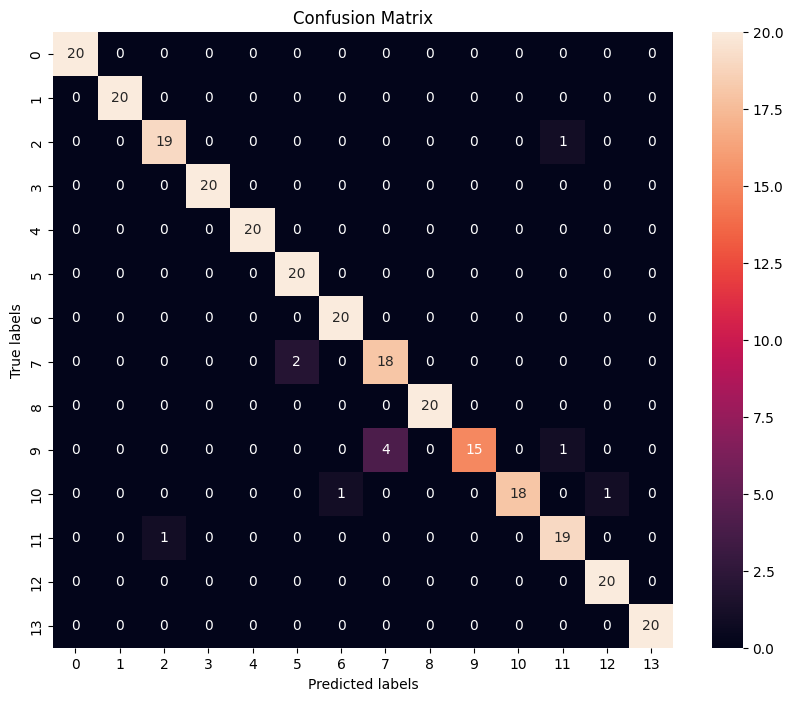

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(X_by_examples_train)

# Initialize the confusion matrix
conf_matrix = np.zeros((num_classes, num_classes))

# Iterate over all classes and their corresponding test images
for true_class in range(num_classes):
    for test_img in X_by_examples_test[true_class]:
        test_img_expanded = np.expand_dims(test_img, axis=0)
        reconstruction_errors = []

        # Pass the test image through each autoencoder and record the reconstruction error
        for autoencoder in autoencoders:
            reconstructed_img = autoencoder.predict(test_img_expanded)
            reconstruction_error = np.mean(np.power(test_img_expanded - reconstructed_img, 2))
            reconstruction_errors.append(reconstruction_error)

        # Find the predicted class based on the minimum reconstruction error
        predicted_class = np.argmin(reconstruction_errors)
        conf_matrix[true_class, predicted_class] += 1

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


In [ ]:
label_map

{'Body centered cubic': 0,
 'Column': 1,
 'Diamond': 2,
 'Re-entrant': 3,
 'Kelvin cell': 4,
 'IsoTruss': 5,
 'Columns': 6,
 'Octet': 7,
 'Face centered cubic': 8,
 'Fluorite': 9,
 'Simple cubic': 10,
 'Truncated octahedron': 11,
 'Truncated cube': 12,
 'Weaire-Phelan': 13}

In [ ]:

print(selection_group, image_from_group)


in_number, out_number=0,0
for in_group_index in range(len(X_by_examples_test[selection_group])):

      #gets the image from the test group
      new_img=X_by_examples_test[image_from_group][in_group_index]
      new_img= np.expand_dims(new_img, axis=0)

      #gets the reconstructed image
      autoencoded_new_img = autoencoders[selection_group].predict(new_img, verbose=0)

      #calculates the reconstruction error sum
      reconstruction_error = binary_crossentropy(new_img, autoencoded_new_img)
      rec_error=np.sum(reconstruction_error)

      #thresholds the reconstruction error with the groups error
      if rec_error>rec_list[selection_group]*2.4:
        out_number+=1
      else:
        in_number+=1

print(in_number)

def loyalty_checker(autoencoder_list, img, preverdict, rec_list):
  '''This is a function for detecting if a classification is correct or if it
  is the overconfidence of the classifier. The inputs are the autoencder list containing
  the autoencoder for each class, the image being tested, the classification of the classifier
  and the mean reconstruction error sum list conatinaing data for each lattice type.'''

  autoencoded_new_img = autoencoder_list[preverdict].predict(img, verbose=0)
  reconstruction_error = binary_crossentropy(img, autoencoded_new_img)
  rec_error=np.sum(reconstruction_error)

  if rec_error>rec_list[preverdict]*2.4:
    return False
  else:
    return True

input_path=input("Please give the path of a 4 channel image or a zip. For 4 channel images,\
any index greater than 200 was not used on either training or testing of models,\
so feel free to use them. Enter 'q' to stop.\n")

#As I tried transfer learning earlier, I was changing the model I used when
#I encountered new data. This things here are relics of that.
last_model=lattice_classifier
new_lattice_types=[]
novelty_counter=0
while input_path!="q":

  #checks the inputs type
  if input_path[-4:]==".png":
    new_img=Image.open(input_path)
  elif input_path[-4:]==".zip":
    zip_name=input_path.split("/")[-1]

    #checks wether the input is transformed to a 4 channel img
    if zip_name in zip2img_map.keys():
      img_name=zip2img_map[zip_name]
      folder_name=zip_name.lstrip('1234567890')[:-4]

      #sets the path to the corresponding image file
      input_path=f"/content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}"
      print(f"4 channel img found on /content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}")
      new_img=Image.open(input_path)


    else:
      print("There is no such 4 channel image, your zip doesn't contain lattices...\n")
      input_path=input("Please give the path of a 4 channel image or a zip. For 4 channel images,\
      any index greater than 200 was not used on either training or testing of models,\
      so feel free to use them. Enter 'q' to stop.\n")
      continue
  new_img = np.array(new_img)
  new_img=new_img/255
  new_img= np.expand_dims(new_img, axis=0)

  #gets lattice type as number by predicting through classifier
  type_number=int(np.argmax(last_model.predict(new_img)))

  #gets lattice type name from label map
  type_text=new_inv_map[type_number]
  print(f"Preliminarily it is {type_text},\
  but gotta check if it is an overconfidence against a novelty")
  if type_text not in new_lattice_types:
    #checks wether it is realy from that class or a novelty using loyalty_checker
    #function
    is_inlier=loyalty_checker(autoencoders, new_img, type_number, rec_list)

    if is_inlier:
      print("It really is an inlier\n")
    else:
      print("It is not really from this group. We have an alien\n")


  input_path=input("Please give the path of a 4 channel image or a zip. For 4 channel images,\
  any index greater than 200 was not used on either training or testing of models,\
   so feel free to use them. Enter 'q' to stop.\n")


iiinv_map = {label_map[k] : k for k in label_map}

X_train_tiny=np.concatenate([latt_type[:3] for latt_type in X_by_examples], axis=0)

y_train_tiny=[i for i in range(11) for k in range(3)]

y_train_tiny = tf.keras.utils.to_categorical(y_train_tiny).astype(int)

input_path=input("Please give the path of an image. Any index greater than 200\
was not used on either training or testing of models, so feel free to use them.\
Enter 'q' to stop.\n")

last_model=lattice_classifier
new_lattice_types=[]
novelty_counter=0
while input_path!="q":
  if input_path[:-4]==".png":
    new_img=Image.open(input_path)
  elif input_path[:-4]==".zip":
    zip_name=input_path.split("/")[-1]
    if zip_name in zip2img_map.keys():
      img_name=zip2img_map[zip_name]
      folder_name=zip_name.lstrip('1234567890')[:-4]
      input_path=f"/content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}"
      print(f"4 channel img found on /content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}")
      new_img=Image.open(input_path)
    else:
      print("There is no such 4 channel image, your zip doesn't contain lattices...")
      continue
  new_img = np.array(new_img)
  new_img=new_img/255

  new_img= np.expand_dims(new_img, axis=0)
  type_number=int(np.argmax(last_model.predict(new_img)))
  type_text=new_inv_map[type_number]
  print(f"Preliminarily it is {type_text},\
  but gotta check if it is an overconfidence against a novelty")
  if type_text not in new_lattice_types:
    is_inlier=loyalty_checker(autoencoders, new_img, type_number, rec_list)

    if is_inlier:
      print("It really is an inlier")
    else:
      print("It is not really from this group. Could you give 2 more of this, so it can learn?")
      input_path=input()

      if input_path[:-4]==".png":
        new_img=Image.open(input_path)
      elif input_path[:-4]==".zip":
        zip_name=input_path.split("/")[-1]
      if zip_name in zip2img_map.keys():
        img_name=zip2img_map[zip_name]
        folder_name=zip_name.lstrip('1234567890')[:-4]
        input_path=f"/content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}"
        print(f"4 channel img found on /content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}")
      new_img2=Image.open(input_path)

      new_img2=Image.open(new_img2)
      new_img2 = np.array(new_img2)
      new_img2=new_img/255


      if input_path[:-4]==".png":
        new_img=Image.open(input_path)
      elif input_path[:-4]==".zip":
        zip_name=input_path.split("/")[-1]
      if zip_name in zip2img_map.keys():
        img_name=zip2img_map[zip_name]
        folder_name=zip_name.lstrip('1234567890')[:-4]
        input_path=f"/content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}"
        print(f"4 channel img found on /content/drive/MyDrive/me536_final_countdown/sep_multi_channel_images/{folder_name}/{img_name}")
      new_img3=Image.open(input_path)

      new_img3=input()
      new_img3=Image.open(new_img3)
      new_img3 = np.array(new_img3)
      new_img3=new_img/255


      last_layer_of_classifier=last_model.layers[-2]
      new_class_count=last_model.layers[-1].output_shape[1]+1
      new_dense_layer=tf.keras.layers.Dense(new_class_count, activation='softmax')(last_layer_of_classifier.output)
      new_lattice_classifier=Model(inputs=last_model.input, outputs=new_dense_layer)

      for layer in lattice_classifier.layers[:-1]:
        layer.trainable = False
      # X_train_new=np.concatenate((X_train, new_img, new_img2, new_img3), axis=0)

      if novelty_counter==0:

        # y_train_tiny=np.hstack((y_train_tiny, np.zeros((33,1))))

        novelty_label_train=np.zeros((3, new_class_count))
        novelty_label_train[:,[-1]]=np.ones((3,1))
        novelty_label_train=novelty_label_train.astype(int)
        # novelty_label_train=np.concatenate((y_train_tiny, novelty_label_train), axis=0)


        # novelty_train=np.concatenate((X_train_tiny, new_img, new_img2, new_img3), axis=0)
        novelty_train=np.concatenate((new_img, new_img2, new_img3), axis=0)


      else:
        new_rows=np.zeros((3, new_class_count))
        new_rows[:,[-1]]=np.ones((3,1))
        new_rows=new_rows.astype(int)
        novelty_label_train=np.hstack((novelty_label_train, np.zeros((novelty_label_train.shape[0],1))))
        novelty_label_train=np.concatenate((novelty_label_train, new_rows), axis=0)

        novelty_train=np.concatenate((novelty_train, new_img, new_img2, new_img3), axis=0)

      opt = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.9999, epsilon=1e-8, amsgrad=False)
      new_lattice_classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

      early_stop = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', min_delta=0.001, patience=5, mode='max', restore_best_weights=True)

      new_lattice_classifier.fit(novelty_train, novelty_label_train, epochs=30, batch_size=3, validation_split=0.4, shuffle=True, callbacks=[early_stop])

      new_label_map[f"NewLattice{novelty_counter}"]=new_class_count-1
      new_inv_map[new_class_count-1]=f"NewLattice{novelty_counter}"
      new_lattice_types.append(f"NewLattice{novelty_counter}")


      print(f"New lattice type called NewLattice{novelty_counter} is defined. You can give it a try!")
      last_model=new_lattice_classifier
      novelty_counter+=1
  else:
    print("Well it seems like this type is learned on the fly, so there isn't\
     enough data to crosscheck this classification.")

  input_path=input("Please give the path of an image. Any index greater than 200\
  was not used on either training or testing of models, so feel free to use them.\
  Enter 'q' to stop.\n")


means, stds, rec_errs=[], [], []

for autoencoder, image_set in zip(autoencoders, X_by_examples_train):

  #reconstructing data
  autoencoded_imgs = autoencoder.predict(image_set)

  #getting the simple difference mean as well as binary crossentropy error means
  mean = np.mean(np.power(image_set - autoencoded_imgs, 2), axis=0)
  reconstruction_error = binary_crossentropy(image_set, autoencoded_imgs)
  std = np.std(mean)

  rec_errs.append(reconstruction_error)
  means.append(mean)
  stds.append(std)

rec_list=[np.mean(rec_errs[i], axis=0).sum() for i in range(11)]


#randomly selecting 2 groups to crosscheck encoders with different images
selection_group, image_from_group = sample(range(11), 2)
is_same=False

if is_same:
  selection_group, image_from_group = selection_group, selection_group


print(selection_group, image_from_group)


in_number, out_number=0,0
for in_group_index in range(len(X_by_examples_test[selection_group])):

      #gets the image from the test group
      new_img=X_by_examples_test[image_from_group][in_group_index]
      new_img= np.expand_dims(new_img, axis=0)

      #gets the reconstructed image
      autoencoded_new_img = autoencoders[selection_group].predict(new_img, verbose=0)

      #calculates the reconstruction error sum
      reconstruction_error = binary_crossentropy(new_img, autoencoded_new_img)
      rec_error=np.sum(reconstruction_error)

      #thresholds the reconstruction error with the groups error
      if rec_error>rec_list[selection_group]*2.4:
        out_number+=1
      else:
        in_number+=1

print(in_number)

def loyalty_checker(autoencoder_list, img, preverdict, rec_list):
  '''This is a function for detecting if a classification is correct or if it
  is the overconfidence of the classifier. The inputs are the autoencder list containing
  the autoencoder for each class, the image being tested, the classification of the classifier
  and the mean reconstruction error sum list conatinaing data for each lattice type.'''

  autoencoded_new_img = autoencoder_list[preverdict].predict(img, verbose=0)
  reconstruction_error = binary_crossentropy(img, autoencoded_new_img)
  rec_error=np.sum(reconstruction_error)

  if rec_error>rec_list[preverdict]*2.4:
    return False
  else:
    return True

4 5
20


KeyboardInterrupt: Interrupted by user

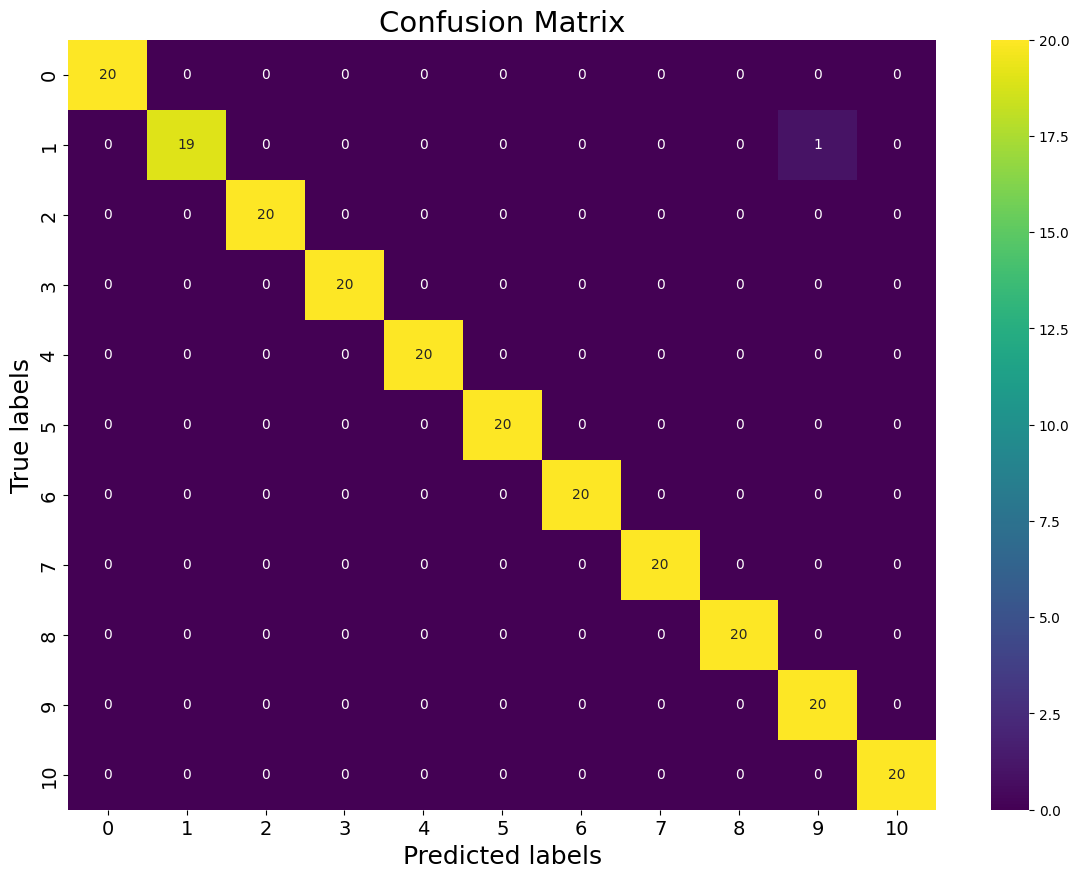

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have your confusion matrix 'conf_matrix' ready
conf_matrix = np.array([
 [20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  1,  0],
 [ 0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20]
])

# Calculate the percentage of each value in relation to the row (true labels)
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(14, 10))  # Larger figure size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='viridis', ax=ax)

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font)
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust to fit

plt.show()
